In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sb
import numpy as np
import pandas as pd

plt.style.use('ggplot')

# Helper function

In [2]:
from sklearn.manifold import TSNE
from matplotlib import offsetbox

def virtualize_2d(X, y_pred, dataset, cmap, n_clusters):
    X_embedded = TSNE(
        n_components=2, 
        perplexity=20, 
        verbose=True, 
        n_iter=3000
    ).fit_transform(X)
    # normalize
    X_min, X_max = np.min(X_embedded, 0), np.max(X_embedded, 0)
    X_norm = (X_embedded - X_min) / (X_max - X_min)
    # draw picture with ground truth image and prediction result
    palette = np.array(sb.color_palette("hls", n_clusters))
    plt.figure(figsize=(20, 15))
    plt.scatter(X_norm[:, 0], X_norm[:, 1], c=palette[y_pred])
    ax = plt.subplot(111)
    shown_images = np.array([[1., 1.]])
    for i in range(dataset.data.shape[0]):
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(
                dataset.images[i], 
                cmap=cmap
            ),
            X_norm[i],
            bboxprops=dict(edgecolor=palette[y_pred[i]])
        )
        ax.add_artist(imagebox)
    plt.show()

# MNIST

0


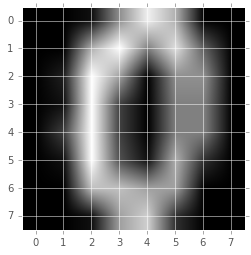

In [3]:
from sklearn.datasets import load_digits

digits = load_digits()
n_samples, h, w = digits.images.shape
plt.imshow(digits.images[10], cmap=plt.cm.gray)
print(digits.target[10])

cluster=10, v_measure_score=0.746876635572
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 7.683244
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.291072
[t-SNE] Error after 225 iterations: 1.291072


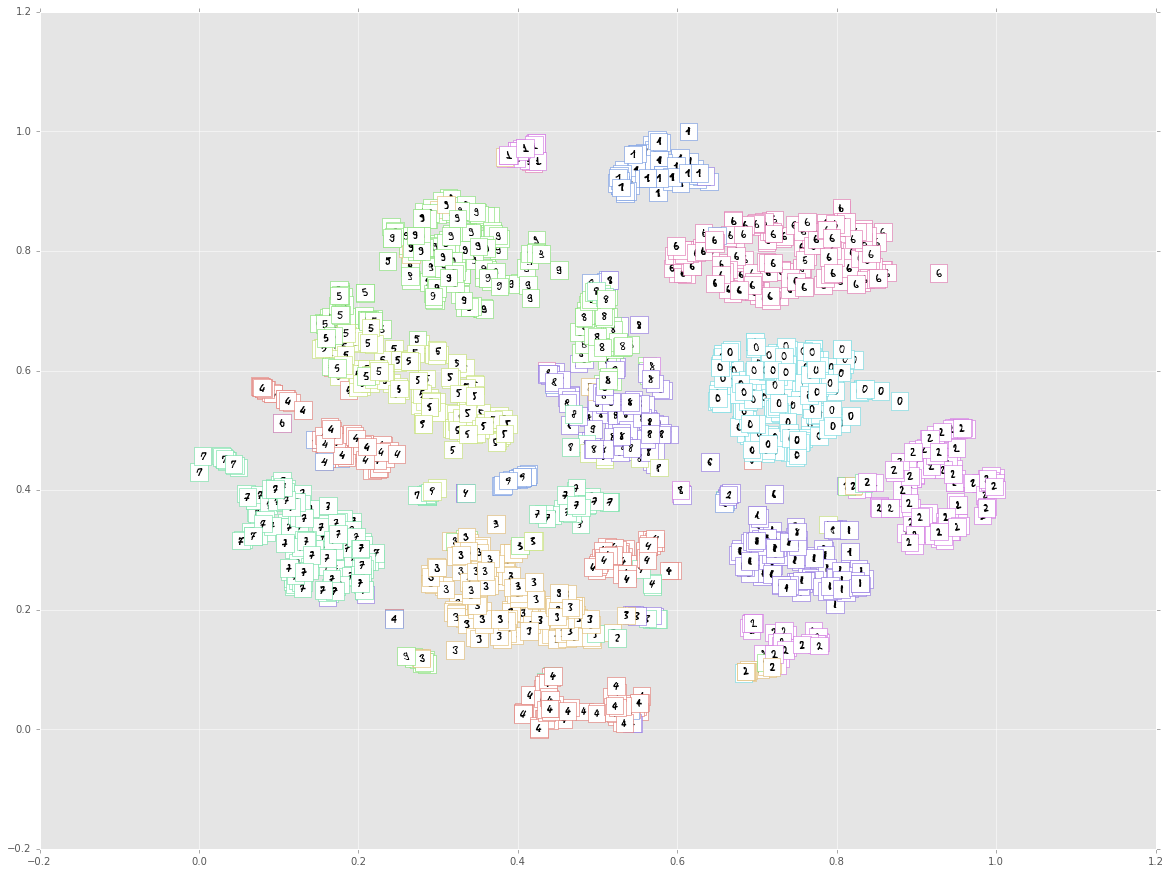

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score

X = digits.data
y_true = digits.target
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
y_pred = kmeans.labels_
score = v_measure_score(y_true, y_pred)
print('cluster={}, v_measure_score={}'.format(n_clusters, score))
virtualize_2d(X, y_pred, digits, plt.cm.gray_r, n_clusters)

# Labeled Faces in the Wild Dataset

George W Bush


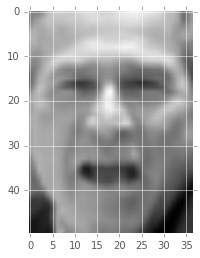

In [5]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
plt.imshow(lfw_people.images[10], cmap=plt.cm.gray)
print(lfw_people.target_names[lfw_people.target[10]])

# K-Means

cluster=7, v_measure_score=0.0367776421678
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1288
[t-SNE] Computed conditional probabilities for sample 1288 / 1288
[t-SNE] Mean sigma: 399.663100
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.549085
[t-SNE] Error after 175 iterations: 1.549085


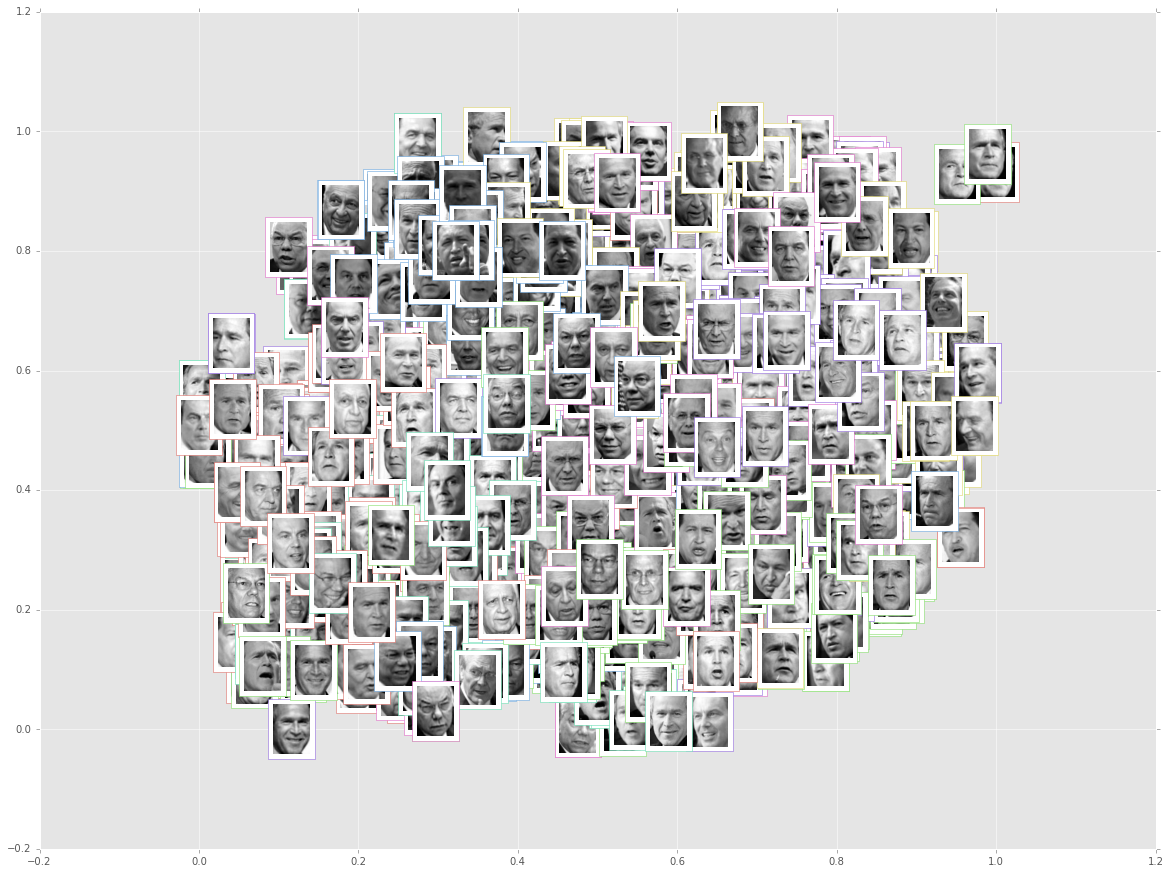

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score

X = lfw_people.data
y_true = lfw_people.target
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
y_pred = kmeans.labels_
score = v_measure_score(y_true, y_pred)
print('cluster={}, v_measure_score={}'.format(n_clusters, score))
virtualize_2d(X, y_pred, lfw_people, plt.cm.gray, n_clusters)

# PCA + K-Means

cluster=7, v_measure_score=0.0616699589578
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1288
[t-SNE] Computed conditional probabilities for sample 1288 / 1288
[t-SNE] Mean sigma: 2.770790
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.379013
[t-SNE] Error after 175 iterations: 1.379013


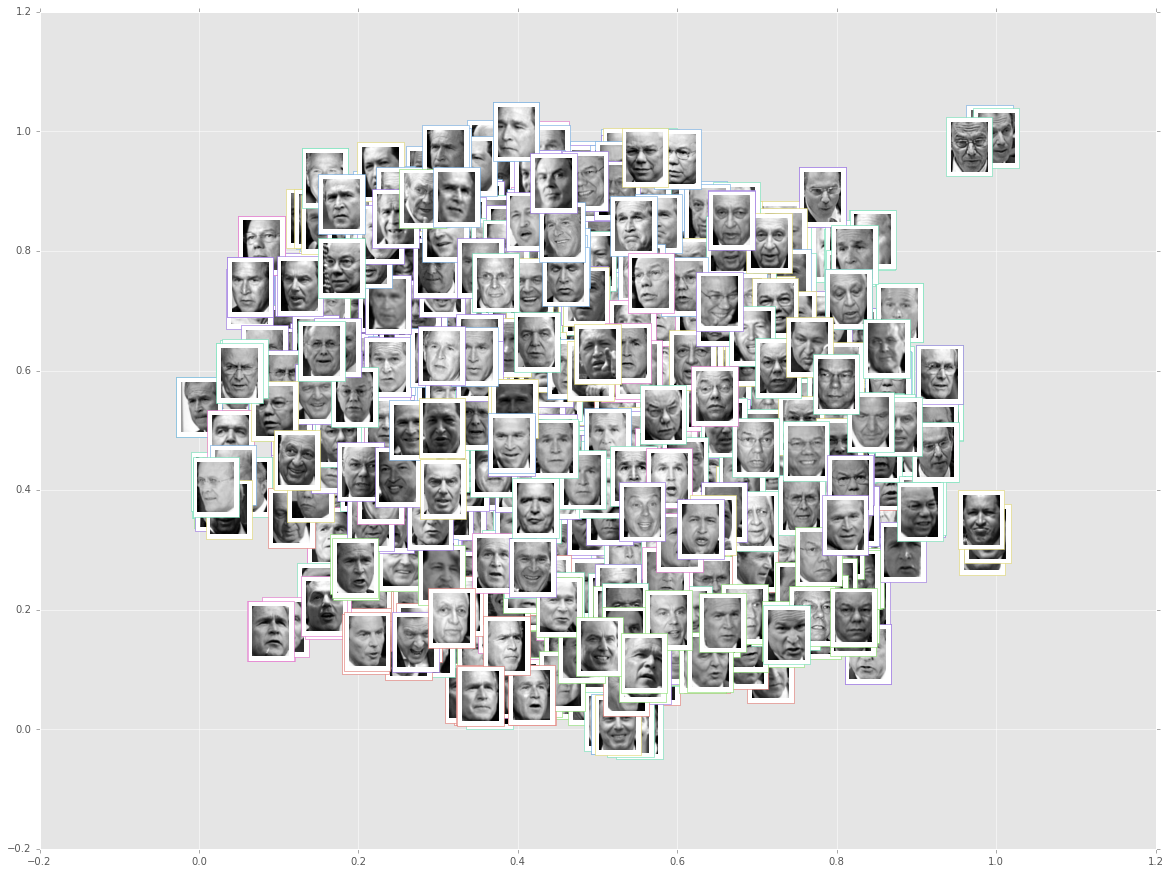

In [7]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import v_measure_score

X = lfw_people.data
y_true = lfw_people.target
n_clusters = 7
n_components = 94 # range check between 10 to 100

X_pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit_transform(X)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_pca)
y_pred = kmeans.labels_
score = v_measure_score(y_true, y_pred)
print('cluster={}, v_measure_score={}'.format(n_clusters, score))
virtualize_2d(X_pca, y_pred, lfw_people, plt.cm.gray, n_clusters)

# Autoencoder + K-Means

(1288, 1850)
(1288,)
cluster=7, v_measure_score=0.0373700123239
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1288
[t-SNE] Computed conditional probabilities for sample 1288 / 1288
[t-SNE] Mean sigma: 1.853515
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.418803
[t-SNE] Error after 125 iterations: 1.418803


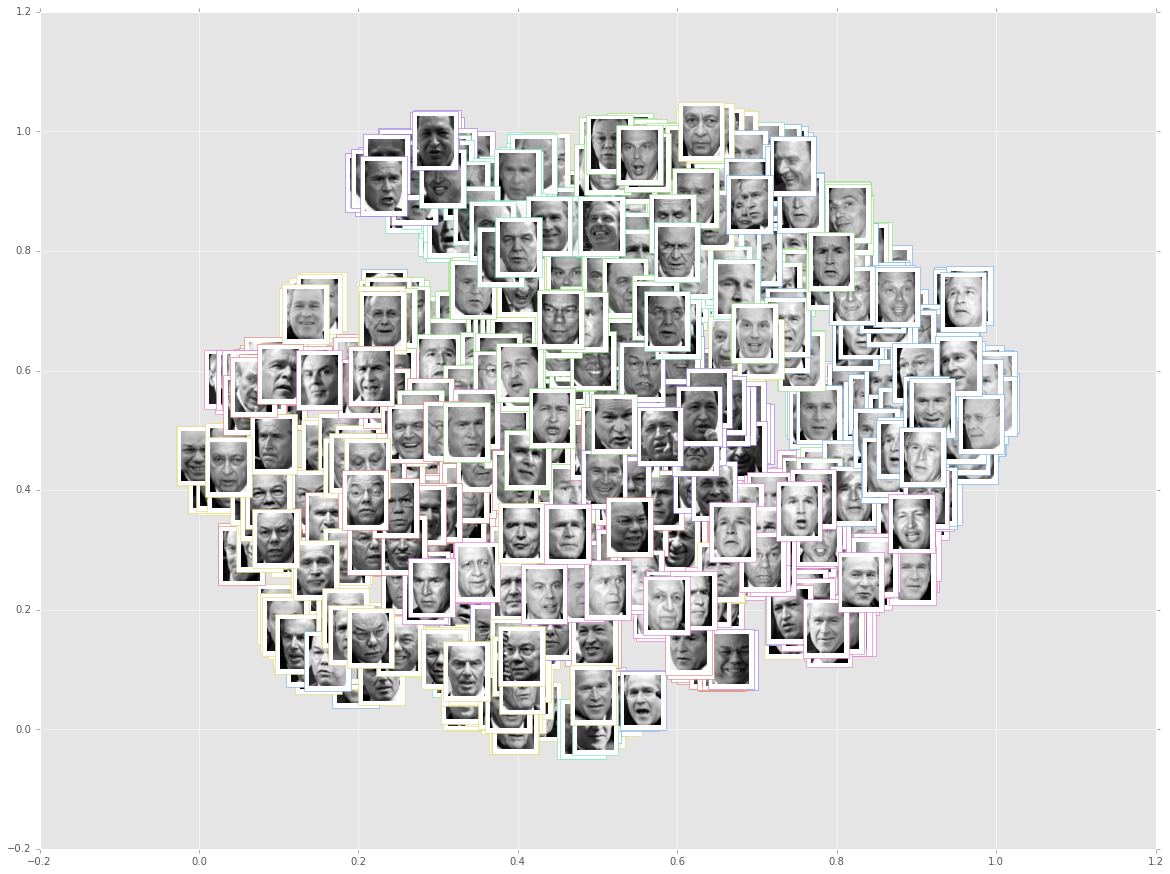

In [10]:
from keras.layers import Input, Dense
from keras.models import Model

from sklearn.cluster import KMeans
from sklearn.feature_extraction import image
from sklearn.metrics.cluster import v_measure_score

X = lfw_people.data
y_true = lfw_people.target
n_clusters = 7
encoding_dim = 16
print X.shape
print y_true.shape


# normalize
X_ae = X.astype('float32')
X_min, X_max = np.min(X_ae, 0), np.max(X_ae, 0)
X_ae = (X_ae - X_min) / (X_max - X_min)
X_ae = X_ae.reshape((len(X_ae), np.prod(X_ae.shape[1:])))

# auto-encoder
img_dim = X_ae.shape[1]
input_img = Input(shape=(img_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(img_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(
    X_ae, X_ae,
    epochs=1000,
    batch_size=256,
    shuffle=True,
    validation_split=0.2,
    verbose=False
)

X_encoded = encoder.predict(X_ae)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_encoded)
y_pred = kmeans.labels_
score = v_measure_score(y_true, y_pred)
print('cluster={}, v_measure_score={}'.format(n_clusters, score))
virtualize_2d(X_encoded, y_pred, lfw_people, plt.cm.gray, n_clusters)